In [1]:
import os
import pickle
import networkx as nx
from scipy import integrate
import numpy as np
from scipy.stats import t
import math

In [2]:
def load_graph(path):
    with open(path, 'rb') as f:
        G = pickle.load(f)
        return G

In [3]:
def load_results_step(network,step):
    if os.path.isfile("exps/exps_%s_%d.pickle"%(network,step)): 
        with (open("exps/exps_%s_%d.pickle"%(network,step), "rb")) as openfile:
            return pickle.load(openfile)
    else:
        return False

In [4]:
def get_number_runs(network):
    runs=[]
    for i in os.listdir("exps/"):
        sub=i.split("_")
        if sub[1]==network:
            runs.append(sub[2].split(".")[0])
    assert int(sorted(runs)[-1])==len(runs)-1
    return int(sorted(runs)[-1])+1

In [5]:
def gather_results(network, low_memory=False, N_EXEC=0):
    if not N_EXEC:
        N_EXEC=get_number_runs(network)
    res={network:{}}
    res[network]["fails"]={}
    res[network]["recs"]={}
    for i in range(N_EXEC):
        aux=load_results_step(network,i)
        res[network]["fails"][i]=aux[network]["fails"][i]
        res[network]["recs"][i]=aux[network]["recs"][i]
        
    if low_memory:
        #recs
        for i in res[network]["recs"]:
            for e in res[network]["recs"][i]:
                del res[network]["recs"][i][e]["added_edges"]
                del res[network]["recs"][i][e]["Gfail"]            
        #fails
        for i in res[network]["fails"]:
            del res[network]["fails"][i]["G"]
            del res[network]["fails"][i]["removed_edges"]
    return res

In [6]:
def number_of_edges(network):
    return len(Ls[network].edges())

In [7]:
def number_of_runs(network):
    return len(exps[network]["fails"])

In [8]:
def compute_sfs(network, percentage):
    steps=round(number_of_edges(network)*percentage)
    sfs=[]
    for i in range(number_of_runs(network)):
        aux=exps[network]["fails"][i]["Reg"][:steps+1]
        sf=integrate.trapezoid([1-x for x in aux],dx=100/number_of_edges(network))
        sfs.append(sf)
    return sfs

In [9]:
def compute_srs(network, percentage):
    steps=round(number_of_edges(network)*percentage)
    srs=[]
    for i in range(number_of_runs(network)):
        aux=exps[network]["recs"][i][steps]["Reg"]
        last_fail=exps[network]["fails"][i]["Reg"][steps]
        sr=integrate.trapezoid([last_fail]+aux, dx=100/number_of_edges(network))
        srs.append(sr)
    return srs

In [10]:
nws = ['amsterdam', 'athens', 'atlanta', 'baltimore', 'berlin', 'bilbao', 'boston', 'brussels', 'budapest', 'buenosaires', 
       'cairo', 'chicago', 'cleveland', 'copenhagen', 'dubai', 'genoa', 'helsinki', 'hyderabad', 'kobe', 'kochi', 'lille',
       'lisbon', 'london', 'losangeles', 'lyon', 'madrid', 'malaga', 'marseille', 'milan', 'montreal','naples', 'newyork',
       'nuremberg', 'oslo', 'paris', 'philadelphia', 'prague', 'rennes', 'rome', 'rotterdam', 'sanfrancisco', 'santiago',
       'stockholm', 'toronto', 'toulouse', 'turin', 'valencia', 'vancouver', 'vienna', 'warsaw', 'washington']

excepted_nws=[]

nws_size=[]
for network in list(set(nws)-set(excepted_nws)):    
    L = load_graph("spaces/L/L-%s.pkl"%network)
    size = len(L.edges())
    nws_size.append((network,size))
nws_size=sorted(nws_size, key=lambda x:x[1])
    
# KEEP ONLY NETWORKS WITH AT LEAST 50 nodes
nws_size=[a for a in nws_size if a[1]>=50]

In [11]:
INITIAL_EXEC=10
exps={}
Ls={}

mean_sfs={}
mean_srs={}

for f in [.25,.5,.75,1]:
    mean_sfs[f]={}
    mean_srs[f]={}

for nw, _ in nws_size:
    print(nw)
    Ls[nw]=load_graph("spaces/L/L-%s.pkl"%nw)

    #Load results
    res=gather_results(nw, low_memory=True)
    
    exps.update(res)
        
    for f in [.25,.5,.75,1]:
        mean_sfs[f][nw]=np.mean(compute_sfs(nw,f))
        mean_srs[f][nw]=np.mean(compute_srs(nw,f))

kobe
naples
marseille
warsaw
toulouse
atlanta
amsterdam
lyon
copenhagen
bilbao
budapest
nuremberg
boston
sanfrancisco
lisbon
dubai
vancouver
philadelphia
hyderabad
prague
lille
brussels
cairo
athens
montreal
rotterdam
rome
toronto
buenosaires
washington
valencia
stockholm
oslo
vienna
milan
chicago
santiago
berlin
madrid
london
paris
newyork


In [12]:
pip install folium

In [14]:
import folium

# Calculate the average latitude and longitude to center the map
average_lat = sum(node_data['lat'] for _, node_data in data.nodes(data=True)) / data.number_of_nodes()
average_lon = sum(node_data['lon'] for _, node_data in data.nodes(data=True)) / data.number_of_nodes()

# Create a map centered at the average location
m = folium.Map(location=[average_lat, average_lon], zoom_start=14)

# Add a marker for each node, including more attributes in the popup
for node, attr in data.nodes(data=True):
    # Format additional node attributes for the popup
    additional_info = f"Name: {attr.get('name', 'Unnamed')}<br>"
    additional_info += f"Lat: {attr['lat']}<br>Lon: {attr['lon']}<br>"
    if 'original_ids' in attr:
        additional_info += f"Original IDs: {attr['original_ids']}<br>"
    
    folium.Marker(
        [attr['lat'], attr['lon']],
        popup=folium.Popup(additional_info, max_width=200)  # Using folium.Popup to accommodate potentially long text
    ).add_to(m)

# Draw lines for edges (optional, as before)
for edge in data.edges():
    source_node, target_node = edge
    if source_node in data.nodes() and target_node in data.nodes():
        latlon_source = [data.nodes[source_node]['lat'], data.nodes[source_node]['lon']]
        latlon_target = [data.nodes[target_node]['lat'], data.nodes[target_node]['lon']]
        
        folium.PolyLine(locations=[latlon_source, latlon_target], color="blue", weight=2.5, opacity=1).add_to(m)

# Display the map
m


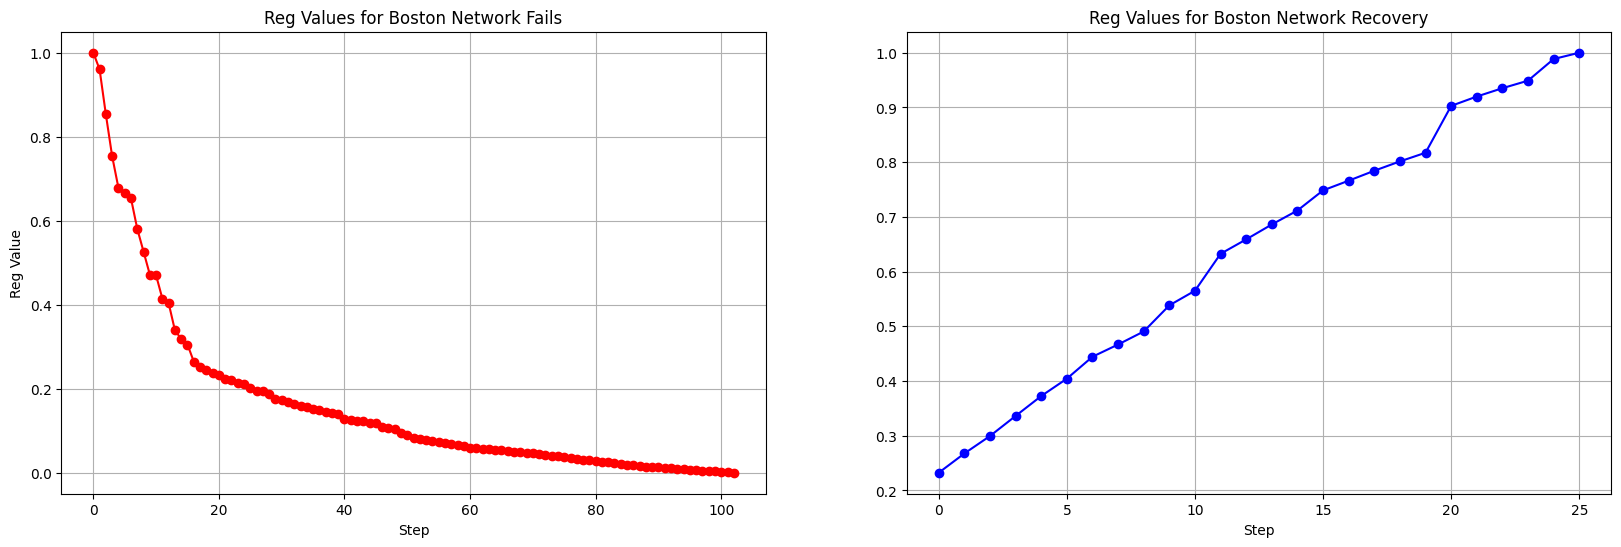

In [15]:
import matplotlib.pyplot as plt

# Assuming 'exps' is your dictionary and contains the 'boston' data
boston_fails_reg_values = exps['boston']['fails'][0]['Reg']
boston_recs_reg_values = exps['boston']['recs'][0][26]['Reg']

# Create lists of step numbers equal in length to the 'Reg' values for the x-axis
steps_fails = list(range(len(boston_fails_reg_values)))
steps_recs = list(range(len(boston_recs_reg_values)))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plotting failure values
axs[0].plot(steps_fails, boston_fails_reg_values, marker='o', linestyle='-', color='r')
axs[0].set_title('Reg Values for Boston Network Fails')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Reg Value')
axs[0].grid(True)

# Plotting recovery values
axs[1].plot(steps_recs, boston_recs_reg_values, marker='o', linestyle='-', color='b')
axs[1].set_title('Reg Values for Boston Network Recovery')
axs[1].set_xlabel('Step')
# axs[1].set_ylabel('Reg Value')  # You might omit this if you want to keep the y-axis labels uncluttered
axs[1].grid(True)

plt.show()


In [16]:
import pickle

# Path to your pickle file
pickle_path = "spaces/L/L-newyork.pkl"

# Load the content from the pickle file
with open(pickle_path, 'rb') as file:
    data = pickle.load(file)

In [17]:
import folium

# Calculate the average latitude and longitude to center the map
average_lat = sum(node_data['lat'] for _, node_data in data.nodes(data=True)) / data.number_of_nodes()
average_lon = sum(node_data['lon'] for _, node_data in data.nodes(data=True)) / data.number_of_nodes()

# Create a map centered at the average location
m = folium.Map(location=[average_lat, average_lon], zoom_start=14)

# Add a marker for each node, including more attributes in the popup
for node, attr in data.nodes(data=True):
    # Format additional node attributes for the popup
    additional_info = f"Name: {attr.get('name', 'Unnamed')}<br>"
    additional_info += f"Lat: {attr['lat']}<br>Lon: {attr['lon']}<br>"
    if 'original_ids' in attr:
        additional_info += f"Original IDs: {attr['original_ids']}<br>"
    
    folium.Marker(
        [attr['lat'], attr['lon']],
        popup=folium.Popup(additional_info, max_width=200)  # Using folium.Popup to accommodate potentially long text
    ).add_to(m)

# Draw lines for edges (optional, as before)
for edge in data.edges():
    source_node, target_node = edge
    if source_node in data.nodes() and target_node in data.nodes():
        latlon_source = [data.nodes[source_node]['lat'], data.nodes[source_node]['lon']]
        latlon_target = [data.nodes[target_node]['lat'], data.nodes[target_node]['lon']]
        
        folium.PolyLine(locations=[latlon_source, latlon_target], color="blue", weight=2.5, opacity=1).add_to(m)

# Display the map
m


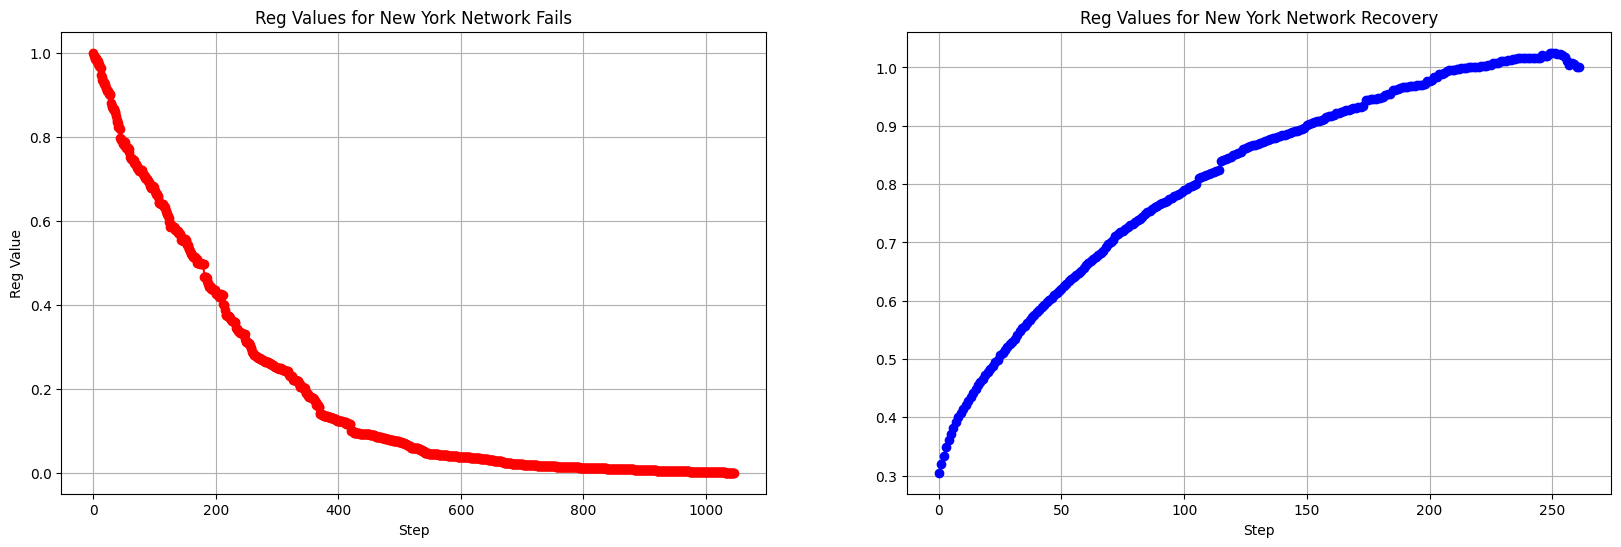

In [18]:
import matplotlib.pyplot as plt

# Assuming 'exps' is your dictionary and contains the 'newyork' data
ny_fails_reg_values = exps['newyork']['fails'][0]['Reg']
ny_recs_reg_values = exps['newyork']['recs'][0][262]['Reg']

# Create lists of step numbers equal in length to the 'Reg' values for the x-axis
steps_fails = list(range(len(ny_fails_reg_values)))
steps_recs = list(range(len(ny_recs_reg_values)))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plotting failure values
axs[0].plot(steps_fails, ny_fails_reg_values, marker='o', linestyle='-', color='r')
axs[0].set_title('Reg Values for New York Network Fails')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Reg Value')
axs[0].grid(True)

# Plotting recovery values
axs[1].plot(steps_recs, ny_recs_reg_values, marker='o', linestyle='-', color='b')
axs[1].set_title('Reg Values for New York Network Recovery')
axs[1].set_xlabel('Step')
# axs[1].set_ylabel('Reg Value')  # You might omit this if you want to keep the y-axis labels uncluttered
axs[1].grid(True)

plt.show()


In [19]:
import networkx as nx

def calculate_network_efficiency(G):
    efficiency_sum = 0
    for source in G.nodes():
        for target in G.nodes():
            if source != target:
                try:
                    shortest_path_length = nx.shortest_path_length(G, source, target, weight='weight')
                    efficiency_sum += 1 / shortest_path_length
                except nx.NetworkXNoPath:
                    continue  # No path between source and target, GTC is considered infinite, its reciprocal is 0
    
    n = len(G.nodes())
    network_efficiency = efficiency_sum / (n * (n - 1))
    return network_efficiency



In [20]:
keys = exps['newyork'].keys()

# Converting keys to a list (for easier use or manipulation)
keys_list = list(keys)

print(keys_list)

['fails', 'recs']


In [21]:
# For Boston L space find the node and edges and also the reacheable nodes when particular links are removed

In [22]:
import pickle
import networkx as nx

# Load the graph from the pickle file
with open("spaces/L/L-boston.pkl", 'rb') as file:
    G = pickle.load(file)

# Print information for nodes
# print("Node Information:")
# for node in G.nodes(data=True):
#     print(node)

# # Print information for edges
# print("\nEdge Information:")
# for edge in G.edges(data=True):
#     print(edge)
#     print("\n")

total_edges = G.number_of_edges()

print("Total number of edges in the graph:", total_edges)   

Total number of edges in the graph: 102


In [23]:
import networkx as nx
import random
import networkx as nx

# Load the graph from the pickle file
with open("spaces/L/L-boston.pkl", 'rb') as file:
    G = pickle.load(file)

# Assuming 'G' is your directed graph (DiGraph)
original_graph = G.copy()  # Make a copy of the original graph to preserve it

# Function to calculate total reachable count
def total_reachable_count(graph):
    return sum(len(nx.descendants(graph, node)) for node in graph.nodes())

# Store the original total reachable count for comparison
original_reachable_count = total_reachable_count(original_graph)

# Percentages of links to remove
percentages = [0,25, 50, 75, 100]

for percentage in percentages:
    # Work on a copy of the original graph for each iteration
    G = original_graph.copy()
    num_edges_to_remove = len(G.edges()) * percentage // 100
    edges_to_remove = random.sample(list(G.edges()), num_edges_to_remove)
    G.remove_edges_from(edges_to_remove)
    
    # Calculate and print the total number of reachable nodes after removal
    current_reachable_count = total_reachable_count(G)
    print(f"After removing {percentage}% of links:")
    print(f"Total reachable nodes: {current_reachable_count}")
    
    # Calculate the decrease in reachability as a percentage
    decrease_percentage = 100 * (original_reachable_count - current_reachable_count) / original_reachable_count
    print(f"Decrease in reachability: {decrease_percentage}%\n")


After removing 0% of links:
Total reachable nodes: 2652
Decrease in reachability: 0.0%

After removing 25% of links:
Total reachable nodes: 282
Decrease in reachability: 89.36651583710407%

After removing 50% of links:
Total reachable nodes: 88
Decrease in reachability: 96.68174962292609%

After removing 75% of links:
Total reachable nodes: 32
Decrease in reachability: 98.79336349924586%

After removing 100% of links:
Total reachable nodes: 0
Decrease in reachability: 100.0%



In [24]:
import networkx as nx

# Load the graph from the pickle file
with open("spaces/L/L-boston.pkl", 'rb') as file:
    G = pickle.load(file)
# Assuming G is your directed graph (DiGraph)
# For an undirected graph, you can simply use nx.Graph()

reachable_nodes = {}
for node in G.nodes():
    reachable = set(nx.descendants(G, node))  # For directed graphs
    # reachable = set(nx.node_connected_component(G, node))  # For undirected graphs
    reachable_nodes[node] = len(reachable)

# reachable_nodes now contains the count of reachable nodes for each node in the graph
print(reachable_nodes)


{0: 51, 1: 51, 2: 51, 3: 51, 4: 51, 5: 51, 6: 51, 7: 51, 8: 51, 9: 51, 10: 51, 11: 51, 12: 51, 13: 51, 14: 51, 15: 51, 16: 51, 17: 51, 18: 51, 19: 51, 20: 51, 21: 51, 22: 51, 23: 51, 24: 51, 25: 51, 26: 51, 27: 51, 28: 51, 29: 51, 30: 51, 31: 51, 32: 51, 33: 51, 34: 51, 35: 51, 36: 51, 37: 51, 38: 51, 39: 51, 40: 51, 41: 51, 42: 51, 43: 51, 44: 51, 45: 51, 46: 51, 47: 51, 48: 51, 49: 51, 50: 51, 51: 51}


In [25]:
import pickle
import networkx as nx

# Load the graph from the pickle file
file_path = "spaces/L/L-boston.pkl"
with open(file_path, 'rb') as file:
    G = pickle.load(file)

# Print edge data along with node features
for edge in G.edges(data=True):
    print("Edge:", edge)
    source_node = edge[0]
    target_node = edge[1]
    source_node_features = G.nodes[source_node]
    target_node_features = G.nodes[target_node]
    print("Source node:", source_node)
    print("Source node features:", source_node_features)
    print("Target node:", target_node)
    print("Target node features:", target_node_features)

Edge: (0, 1, {'shape_id': {'931_0009': 80, '933_0009': 79}, 'direction_id': {'0': 159}, 'headsign': {'Ashmont': 80, 'Braintree': 79}, 'duration_avg': 120.0, 'n_vehicles': 159, 'd': 1705, 'route_I_counts': {1: 159}})
Source node: 0
Source node features: {'lat': 42.395428, 'lon': -71.142483, 'name': 'Alewife', 'original_ids': [7418]}
Target node: 1
Target node features: {'lat': 42.39674, 'lon': -71.121815, 'name': 'Davis', 'original_ids': [7837, 7838]}
Edge: (1, 2, {'shape_id': {'931_0009': 80, '933_0009': 79}, 'direction_id': {'0': 159}, 'headsign': {'Ashmont': 80, 'Braintree': 79}, 'duration_avg': 120.0, 'n_vehicles': 159, 'd': 953, 'route_I_counts': {1: 159}})
Source node: 1
Source node features: {'lat': 42.39674, 'lon': -71.121815, 'name': 'Davis', 'original_ids': [7837, 7838]}
Target node: 2
Target node features: {'lat': 42.3884, 'lon': -71.119149, 'name': 'Porter', 'original_ids': [8440, 8441]}
Edge: (1, 0, {'duration_avg': 186.62576687116564, 'n_vehicles': 163, 'd': 1705, 'route_I

In [26]:
import pickle
import networkx as nx

# Load the graph from the pickle file
file_path = "spaces/P/P-boston.pkl"
with open(file_path, 'rb') as file:
    G = pickle.load(file)

# Print edge data along with node features
for edge in G.edges(data=True):
    print("Edge:", edge)
    source_node = edge[0]
    target_node = edge[1]
    source_node_features = G.nodes[source_node]
    target_node_features = G.nodes[target_node]
    print("Source node:", source_node)
    print("Source node features:", source_node_features)
    print("Target node:", target_node)
    print("Target node features:", target_node_features)


Edge: (0, 1, {'veh': {1: {'0': 8.368421052631579}}, 'avg_wait': 3.5849056603773586, 'edge_color': '#DA291C'})
Source node: 0
Source node features: {'lat': 42.395428, 'lon': -71.142483, 'name': 'Alewife', 'original_ids': [7418]}
Target node: 1
Target node features: {'lat': 42.39674, 'lon': -71.121815, 'name': 'Davis', 'original_ids': [7837, 7838]}
Edge: (0, 2, {'veh': {1: {'0': 8.368421052631579}}, 'avg_wait': 3.5849056603773586, 'edge_color': '#DA291C'})
Source node: 0
Source node features: {'lat': 42.395428, 'lon': -71.142483, 'name': 'Alewife', 'original_ids': [7418]}
Target node: 2
Target node features: {'lat': 42.3884, 'lon': -71.119149, 'name': 'Porter', 'original_ids': [8440, 8441]}
Edge: (0, 3, {'veh': {1: {'0': 8.368421052631579}}, 'avg_wait': 3.5849056603773586, 'edge_color': '#DA291C'})
Source node: 0
Source node features: {'lat': 42.395428, 'lon': -71.142483, 'name': 'Alewife', 'original_ids': [7418]}
Target node: 3
Target node features: {'lat': 42.373362, 'lon': -71.118956,

In [27]:


import pickle

# Path to your pickle file
pickle_path = "spaces/L/L-boston.pkl"

# Load the content from the pickle file
with open(pickle_path, 'rb') as file:
    data = pickle.load(file)

import folium

# Calculate the average latitude and longitude to center the map
average_lat = sum(node_data['lat'] for _, node_data in data.nodes(data=True)) / data.number_of_nodes()
average_lon = sum(node_data['lon'] for _, node_data in data.nodes(data=True)) / data.number_of_nodes()

# Create a map centered at the average location
m = folium.Map(location=[average_lat, average_lon], zoom_start=14)

# Add a marker for each node, including more attributes in the popup
for node, attr in data.nodes(data=True):
    # Format additional node attributes for the popup
    additional_info = f"Name: {attr.get('name', 'Unnamed')}<br>"
    additional_info += f"Lat: {attr['lat']}<br>Lon: {attr['lon']}<br>"
    if 'original_ids' in attr:
        additional_info += f"Original IDs: {attr['original_ids']}<br>"
    
    folium.Marker(
        [attr['lat'], attr['lon']],
        popup=folium.Popup(additional_info, max_width=200)  # Using folium.Popup to accommodate potentially long text
    ).add_to(m)

# Draw lines for edges (optional, as before)
for edge in data.edges():
    source_node, target_node = edge
    if source_node in data.nodes() and target_node in data.nodes():
        latlon_source = [data.nodes[source_node]['lat'], data.nodes[source_node]['lon']]
        latlon_target = [data.nodes[target_node]['lat'], data.nodes[target_node]['lon']]
        
        folium.PolyLine(locations=[latlon_source, latlon_target], color="blue", weight=2.5, opacity=1).add_to(m)

# Display the map
m


In [28]:
city="boston"

In [30]:
import networkx as nx

# Function to print edge information
def print_edge_info(graph, graph_name):
    print(f"Edge information for {graph_name} graph:")
    for u, v, data in graph.edges(data=True):
        print(f"Edge: {u} - {v}, Data: {data}")

# Function to print node information
def print_node_info(graph, graph_name):
    print(f"Node information for {graph_name} graph:")
    for node, data in graph.nodes(data=True):
        print(f"Node: {node}, Data: {data}")


In [31]:
city="boston"

In [32]:
import networkx as nx
import itertools
import random
import copy
import matplotlib.pyplot as plt

# Define constants
ALPHA = 2  # Weight for waiting time
BETA = 5   # Penalty for each transfer
M = 3      # Number of shortest paths to consider


# Calculate GTC for a given path
def calculate_gtc(path, L, P):
    in_vehicle_time = sum(L[u][v]['duration_avg'] for u, v in zip(path[:-1], path[1:]))
    waiting_time = sum(P[u][v]['avg_wait'] for u, v in zip(path[:-1], path[1:]))
    n_transfers = len(path) - 1
    return in_vehicle_time + ALPHA * waiting_time + BETA * n_transfers

# Calculate network efficiency
def calculate_network_efficiency(L, P,city):

    file_path = f"spaces/L/L-{city}.pkl"
    with open(file_path, 'rb') as file:
        G1 = pickle.load(file)
    
    num_nodes=G1.number_of_nodes()
    all_nodes = list(L.nodes())
    gtc_sum = 0
    pairs_count = 0

    for i, source in enumerate(all_nodes):
        for target in all_nodes[i+1:]:  # Avoid duplicate pairs and self-pairs
            try:
                shortest_paths = list(itertools.islice(nx.shortest_simple_paths(L, source, target, weight='duration_avg'), M))
                gtc_values = [calculate_gtc(path, L, P) for path in shortest_paths]
                gtc = min(gtc_values) if gtc_values else float('inf')  # GTC is infinity if no path exists

                if gtc != float('inf'):
                    gtc_sum += 1 / gtc
                    pairs_count += 1
            except nx.NetworkXNoPath:
                continue

    efficiency = gtc_sum / (num_nodes * (num_nodes - 1))
    return efficiency


In [33]:
import networkx as nx

# Assuming 'G' is your graph
density = nx.density(L)
print("Density of the graph:", density)

Density of the graph: 0.06060606060606061


In [34]:


sigma=0.25
city="boston"
file_path_L = f"spaces/L/L-{city}.pkl"
with open(file_path_L, 'rb') as file:
    L = pickle.load(file)

file_path_P = f"spaces/P/P-{city}.pkl"
with open(file_path_P, 'rb') as file:
    P = pickle.load(file)

import random
import copy
import matplotlib.pyplot as plt

def calculate_performance_ratio_for_edge(L_copy, P, ALPHA, BETA, M, sigma, removed_edge,e_G0):
    # e_G0 = calculate_network_efficiency(L, P)
    e_G0=e_G0
    L1 = copy.deepcopy(L_copy)
    
    # if removed_edge not in L_copy.edges():
    #     return 0  # If the edge is not present, the performance ratio is 0
    
    L1.add_edge(*removed_edge)
    e_Gi_after = calculate_network_efficiency(L1, P,city)
    
    efficiency_ratio = e_Gi_after / e_G0 if e_G0 > 0 else 0
    # print("after edge efficiency is ",efficiency_ratio)
    return efficiency_ratio

def simulate_failure_and_recovery(L, P, ALPHA, BETA, M, sigma):
    num_nodes = L.number_of_nodes()
    num_edges_before_removal = L.number_of_edges()
    e_G0 = calculate_network_efficiency(L, P, city)
    K = int(sigma * num_edges_before_removal)
    L_initial=copy.deepcopy(L)
    # Simulate failure
    removed_edges = []  # Store edges along with their attributes
    efficiency_ratios_failure = [1]
    num_edges_removed = 0
    
    while num_edges_removed < K:
        if len(removed_edges) == num_edges_before_removal:
            print("All edges have been removed. Exiting failure simulation.")
            break
        
        edge_to_remove = random.choice(list(L.edges()))
        if edge_to_remove not in removed_edges:
            # Store the edge and its attributes before removing
            removed_edges.append((edge_to_remove, L.edges[edge_to_remove]))
            num_edges_removed += 1
            L.remove_edge(*edge_to_remove)
            e_Gi = calculate_network_efficiency(L, P, city)
            efficiency_ratio = e_Gi / e_G0 if e_G0 > 0 else 0
            efficiency_ratios_failure.append(efficiency_ratio)
            print(f"Efficiency ratio after removing {num_edges_removed} edges: {efficiency_ratio}")

    # print(removed_edges[0])
    # Calculate F
    F = sum(1 - p for p in efficiency_ratios_failure)

    # Store the last efficiency ratio after failure
    last_efficiency_ratio = efficiency_ratios_failure[-1]

    # Simulate recovery
    efficiency_ratios_recovery = [last_efficiency_ratio]  # Start with the efficiency ratio before recovery
    
    # Create a copy of the graph for recovery evaluation
    L_last_failure = copy.deepcopy(L)
    last_failure_ratio=calculate_network_efficiency(L_last_failure, P, city)/e_G0
    i=1
    while removed_edges:
        max_efficiency_ratio = 0
        best_edge = None

        for edge, attributes in removed_edges:
            L_last_failure.add_edge(*edge, **attributes)  # Add the edge with its attributes
            performance_ratio = calculate_performance_ratio_for_edge(L_last_failure, P, ALPHA, BETA, M, sigma, edge, e_G0)
            
            if performance_ratio > max_efficiency_ratio:
                max_efficiency_ratio = performance_ratio
                best_edge = edge

            L_last_failure.remove_edge(*edge)  # Remove the edge for the next iteration

        # print("best edge is",best_edge)
        # print("best performance is",max_efficiency_ratio)
        
        if best_edge:
            edge_to_add, attributes = removed_edges.pop(removed_edges.index((best_edge, L_initial.edges[best_edge])))
        
            # Add the best edge back to the graph along with its attributes
            L.add_edge(*edge_to_add, **attributes)
        
            # Print the newly added edge attributes
            # print(f"Newly added edge attributes: {attributes}")
        
            efficiency_ratios_recovery.append(calculate_network_efficiency(L, P,city)/e_G0)
            print(f"Efficiency ratio after adding edge {i} for recovery: {calculate_network_efficiency(L, P,city)/e_G0}")
            i=i+1

        else:
            # If no edge was added, break the loop
            break

    # Calculate R
    R = sum(p - last_failure_ratio for p in efficiency_ratios_recovery[1:])

    return F, R, efficiency_ratios_failure, efficiency_ratios_recovery, num_edges_before_removal


F, R, failure_ratios, recovery_ratios, num_edges_before_removal=simulate_failure_and_recovery(L, P, ALPHA, BETA, M, sigma)

Efficiency ratio after removing 1 edges: 1.0
Efficiency ratio after removing 2 edges: 0.9301131882479837
Efficiency ratio after removing 3 edges: 0.8811540763877667
Efficiency ratio after removing 4 edges: 0.8036209958675081
Efficiency ratio after removing 5 edges: 0.768442309014575
Efficiency ratio after removing 6 edges: 0.6294099713158925
Efficiency ratio after removing 7 edges: 0.5629752937205148
Efficiency ratio after removing 8 edges: 0.5629752937205148
Efficiency ratio after removing 9 edges: 0.5629752937205148
Efficiency ratio after removing 10 edges: 0.5629752937205148
Efficiency ratio after removing 11 edges: 0.5390713156130947
Efficiency ratio after removing 12 edges: 0.504497362724062
Efficiency ratio after removing 13 edges: 0.4987278542188562
Efficiency ratio after removing 14 edges: 0.48550584142698
Efficiency ratio after removing 15 edges: 0.47361016258890903
Efficiency ratio after removing 16 edges: 0.4630991880178489
Efficiency ratio after removing 17 edges: 0.4472999

In [ ]:
# Calculate R-F and R/F
RF = R / F if F != 0 else float('inf')
RF_diff = R - F

# Plotting performance efficiency during failure and recovery
x_values_failure = range(len(failure_ratios))
x_values_recovery = range(len(failure_ratios), len(failure_ratios) + len(recovery_ratios))

plt.plot(x_values_failure, failure_ratios, color='red', label='Failure')
plt.plot(x_values_recovery, recovery_ratios, color='green', label='Recovery')

plt.xlabel('Number of Edges Added')
plt.ylabel('Efficiency Ratio')
plt.title('Performance Efficiency during Failure and Recovery')
plt.legend()
plt.grid(True)
plt.show()

print(f"Total number of edges before removal: {num_edges_before_removal}")
print(f"Cumulative Performance Loss (F): {F}")
print(f"Cumulative Performance Gain (R): {R}")
print(f"R - F: {RF_diff}")
print(f"R/F: {RF}")


In [ ]:
# sigma = 0.25
# ALPHA = 2
# BETA = 5
# M = 5



# # Function to simulate failure and recovery for Boston
# def simulate_boston():
#     file_path_L_boston = "spaces/L/L-boston.pkl"
#     with open(file_path_L_boston, 'rb') as file:
#         L_boston = pickle.load(file)

#     file_path_P_boston = "spaces/P/P-boston.pkl"
#     with open(file_path_P_boston, 'rb') as file:
#         P_boston = pickle.load(file)

#     F_boston, R_boston, failure_ratios_boston, recovery_ratios_boston, num_edges_before_removal_boston = simulate_failure_and_recovery(L_boston, P_boston, ALPHA, BETA, M, sigma)
#     return failure_ratios_boston, recovery_ratios_boston

# # Function to simulate failure and recovery for Oslo
# def simulate_oslo():
#     file_path_L_oslo = "spaces/L/L-oslo.pkl"
#     with open(file_path_L_oslo, 'rb') as file:
#         L_oslo = pickle.load(file)

#     file_path_P_oslo = "spaces/P/P-oslo.pkl"
#     with open(file_path_P_oslo, 'rb') as file:
#         P_oslo = pickle.load(file)

#     F_oslo, R_oslo, failure_ratios_oslo, recovery_ratios_oslo, num_edges_before_removal_oslo = simulate_failure_and_recovery(L_oslo, P_oslo, ALPHA, BETA, M, sigma)
#     return failure_ratios_oslo, recovery_ratios_oslo

# failure_ratios_boston, recovery_ratios_boston = simulate_boston()
# failure_ratios_oslo, recovery_ratios_oslo = simulate_oslo()


In [ ]:
# # Plotting for Boston
# plt.figure(figsize=(10, 6))
# plt.plot(failure_ratios_boston, label='Boston Failure', color='red', alpha=0.5)
# plt.xlabel('Percentage of Edges Added/Removed (%)')
# plt.ylabel('Performance Ratio')
# plt.title('Boston Failure: Performance Ratio vs. Percentage of Edges Added/Removed')
# plt.grid(True)
# plt.legend()
# plt.savefig('boston_failure_plot.png', transparent=True)  # Save the plot with transparent background
# plt.close()

# # Plotting for Oslo
# plt.figure(figsize=(10, 6))
# plt.plot(failure_ratios_oslo, label='Oslo Failure', color='pink', alpha=0.5)
# plt.xlabel('Percentage of Edges Added/Removed (%)')
# plt.ylabel('Performance Ratio')
# plt.title('Oslo Failure: Performance Ratio vs. Percentage of Edges Added/Removed')
# plt.grid(True)
# plt.legend()
# plt.savefig('oslo_failure_plot.png', transparent=True)  # Save the plot with transparent background
# plt.close()

# # Overlapping the plots
# plt.figure(figsize=(10, 6))
# plt.imshow(plt.imread('boston_failure_plot.png'), aspect='auto')
# plt.imshow(plt.imread('oslo_failure_plot.png'), aspect='auto')
# plt.axis('off')
# plt.savefig('failure_superimposed.png', transparent=True)# Turn off axis
# plt.show()

In [ ]:
# # Plotting for Boston Recovery
# plt.figure(figsize=(10, 6))
# plt.plot(recovery_ratios_boston, label='Boston Recovery', color='green', alpha=0.5)
# plt.xlabel('Percentage of Edges Added (%)')
# plt.ylabel('Performance Ratio')
# plt.title('Boston Recovery: Performance Ratio vs. Percentage of Edges Added')
# plt.grid(True)
# plt.legend()
# plt.savefig('boston_recovery_plot.png', transparent=True)  # Save the plot with transparent background
# plt.close()

# # Plotting for Oslo Recovery
# plt.figure(figsize=(10, 6))
# plt.plot(recovery_ratios_oslo, label='Oslo Recovery', color='olive', alpha=0.5)
# plt.xlabel('Percentage of Edges Added (%)')
# plt.ylabel('Performance Ratio')
# plt.title('Oslo Recovery: Performance Ratio vs. Percentage of Edges Added')
# plt.grid(True)
# plt.legend()
# plt.savefig('oslo_recovery_plot.png', transparent=True)  # Save the plot with transparent background
# plt.close()

# # Overlapping the recovery plots
# plt.figure(figsize=(10, 6))
# plt.imshow(plt.imread('boston_recovery_plot.png'), aspect='auto')
# plt.imshow(plt.imread('oslo_recovery_plot.png'), aspect='auto')
# plt.axis('off')
# plt.savefig('recovery_superimposed.png', transparent=True)# Turn off axis
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the superimposed images
# failure_superimposed_img = plt.imread('failure_superimposed.png')
# recovery_superimposed_img = plt.imread('recovery_superimposed.png')

# # Get the width of each image
# width_failure, width_recovery = failure_superimposed_img.shape[1], recovery_superimposed_img.shape[1]

# # Calculate the blend region width
# blend_width = int(0.45 * min(width_failure, width_recovery))

# # Crop the blend region from each image
# failure_blend_region = failure_superimposed_img[:, -blend_width:]
# recovery_blend_region = recovery_superimposed_img[:, :blend_width]

# # Calculate the alpha values for blending
# alpha_failure = np.linspace(1, 0, blend_width)
# alpha_recovery = np.linspace(0, 1, blend_width)

# # Blend the images in the overlap region
# blended_blend_region = (alpha_failure[:, np.newaxis] * failure_blend_region) + (alpha_recovery[:, np.newaxis] * recovery_blend_region)

# # Combine the non-blend regions
# left_non_blend = failure_superimposed_img[:, :-blend_width]
# right_non_blend = recovery_superimposed_img[:, blend_width:]

# # Concatenate the blended and non-blend regions
# concatenated_img = np.concatenate((left_non_blend, blended_blend_region, right_non_blend), axis=1)

# # Display the concatenated image
# plt.figure(figsize=(20, 6))
# plt.imshow(concatenated_img)
# plt.axis('off')
# plt.title('Superimposed: Failure and Recovery with 45% Blend')
# plt.show()
